In [1]:

import pickle
import pandas as pd

# Handy list of the different types of encodings
encoding = ['latin1', 'iso8859-1', 'utf-8'][1]

# Change this to your data and saves folders
data_folder = r'../../data/'
saves_folder = r'../../saves/'

def load_object(obj_name):
    pickle_path = saves_folder + 'pickle/' + obj_name + '.pickle'
    try:
        object = pd.read_pickle(pickle_path)
    except:
        with open(pickle_path, 'rb') as handle:
            object = pickle.load(handle)
    
    return(object)

In [2]:

from sklearn.decomposition import PCA
import os

obj_path = saves_folder + 'pickle/gapminder_df.pickle'
if not os.path.isfile(obj_path):
    gapminder_df = pd.read_csv(data_folder + 'csv/gapminder.csv',
                               low_memory=False, encoding=encoding)
else:
    gapminder_df = load_object('gapminder_df')
gapminder_df.columns = ['country_name', 'income_per_person',
                        'alcohol_consumption', 'armed_forces_rate',
                        'breast_cancer_per_100th', 'co2_emissions',
                        'female_employment_rate', 'hiv_rate',
                        'internet_use_rate', 'life_expectancy',
                        'oil_per_person', 'polity_score',
                        'residential_electricity_per_person',
                        'suicide_per_100th', 'employment_rate',
                        'urban_rate']
number_column_list = list(set(gapminder_df.columns) - set(['country_name']))
elite_df = gapminder_df.dropna(how='any').copy()
elite_ndarray = PCA(n_components=2).fit_transform(elite_df[number_column_list])

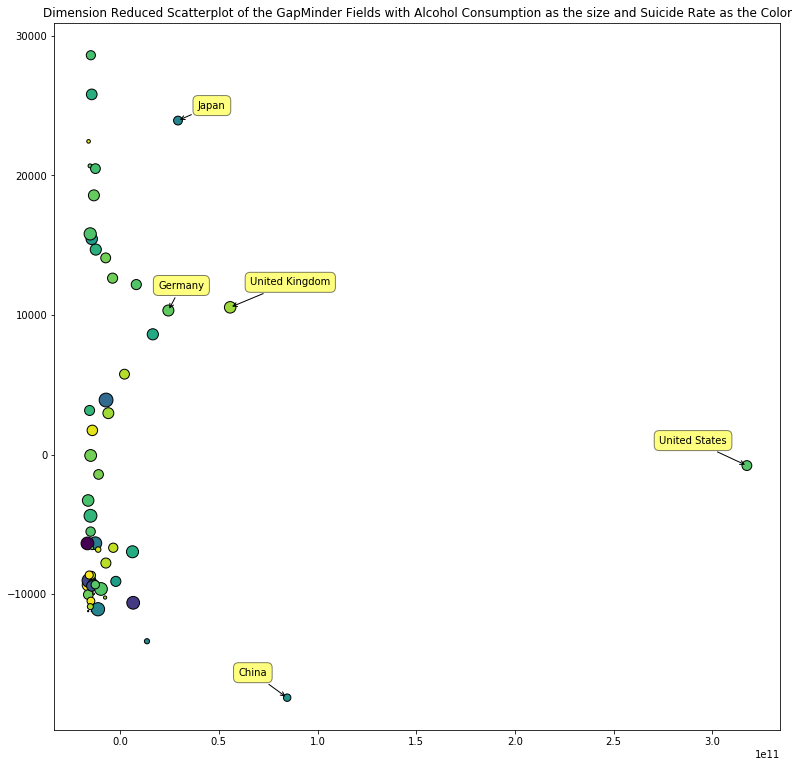

In [3]:

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db = DBSCAN(eps=7750000000, min_samples=2).fit(elite_ndarray)
labels = db.labels_

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, autoscale_on=True)
cmap = plt.get_cmap('viridis_r')
path_collection = ax.scatter(elite_ndarray[:, 0], elite_ndarray[:, 1],
                             s=elite_df['alcohol_consumption']*10,
                             c=elite_df['suicide_per_100th'],
                             edgecolors=(0, 0, 0), cmap=cmap)
for col, label, x, y in zip(labels, elite_df['country_name'],
                            elite_ndarray[:, 0], elite_ndarray[:, 1]):
    if (label == 'Japan'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 10),
                                  textcoords='offset points', ha='left',
                                  va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.5',
                                            fc='yellow', alpha=0.5),
                                  arrowprops=dict(arrowstyle='->',
                                                  connectionstyle='arc3,rad=0'))
    elif (label == 'United Kingdom'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 20),
                                  textcoords='offset points',
                                  ha='left', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.5',
                                            fc='yellow', alpha=0.5),
                                  arrowprops=dict(arrowstyle='->',
                                                  connectionstyle='arc3,rad=0'))
    elif (label == 'China') or (label == 'United States'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-20, 20),
                                  textcoords='offset points',
                                  ha='right', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.5',
                                            fc='yellow', alpha=0.5),
                                  arrowprops=dict(arrowstyle='->',
                                                  connectionstyle='arc3,rad=0'))
    elif (col == 1):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-10, 20),
                                  textcoords='offset points',
                                  ha='left', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.5',
                                            fc='yellow', alpha=0.5),
                                  arrowprops=dict(arrowstyle='->',
                                                  connectionstyle='arc3,rad=0'))
title_text = 'Dimension Reduced Scatterplot of the GapMinder '
title_text += 'Fields with Alcohol Consumption as the size and '
title_text += 'Suicide Rate as the Color'
text = plt.title(title_text)

In [4]:

def create_binned_categories(df, number_of_categories, column_name,
                             prefix):
    out_categorical, percentiles_list = pd.cut([0, 1],
                                               number_of_categories,
                                               retbins=True)
    describe_series = df[column_name].describe(percentiles=percentiles_list[1:-1]).copy()
    bad_list = ['count', 'mean', 'std']
    if (number_of_categories % 2) == 1:
        bad_list += ['50%']
    index_list = [x for x in describe_series.index.tolist() if x not in bad_list]
    bin_list = describe_series.loc[index_list].tolist()
    group_names = [x for x in range(1, len(bin_list))]
    category_series = pd.cut(df[column_name], bin_list,
                             labels=group_names)
    df[prefix+'_categories'] = pd.cut(df[column_name], bin_list,
                                      labels=group_names)
    df[prefix+'_binned'] = pd.cut(df[column_name], bin_list)
    
    # Fix the bottom row
    null_series = df[prefix+'_categories'].isnull()
    bottom_series = (df[prefix+'_categories'] == 1)
    binned_value = df[bottom_series][prefix+'_binned'].min()
    df.loc[null_series, prefix+'_categories'] = 1
    df.loc[null_series, prefix+'_binned'] = binned_value

    return df

In [5]:

import statsmodels.formula.api as smf

def bi_categorical_anova_interpretation(df, ce_column_name,
                                        qr_column_name,
                                        ce_formal_name,
                                        qr_formal_name,
                                        ce_informal_name,
                                        qr_informal_name):
    column_list = [ce_column_name, qr_column_name]
    all_countries_df = df[column_list].dropna().copy()

    all_sd_df = all_countries_df.groupby(ce_column_name).std()
    all_mean_df = all_countries_df.groupby(ce_column_name).mean()

    # Use ols function for calculating the F-statistic and
    # associated p value
    all_ols = smf.ols(formula=qr_column_name+' ~ C('+ce_column_name+')',
                      data=all_countries_df)
    all_fitted = all_ols.fit()
    
    # Figure out the adverbs
    f_pvalue = all_fitted.f_pvalue
    if f_pvalue <= 0.05:
        adverb_significant = 'a significantly'
    else:
        adverb_significant = 'an insignificantly'
    low_mean = all_mean_df.loc[0, qr_column_name]
    high_mean = all_mean_df.loc[1, qr_column_name]
    if high_mean > low_mean:
        adverb_higher = 'higher'
    else:
        adverb_higher = 'lower'

    return ('''<h3>Model Interpretation for ANOVA:</h3><p>When 
    examining the association between ''' +
            qr_formal_name + ' (quantitative response) and ' +
            ce_formal_name + ''' (2 categories, which is the
            categorical explanatory variable), an Analysis of
            Variance (ANOVA) revealed that those countries with a
            higher ''' +
            ce_informal_name + ' reported ' +
            adverb_significant + ' ' +
            adverb_higher + ' ' +
            qr_informal_name + ' (Mean=' +
            str('%.1f' % high_mean) + ', s.d. ±' +
            str('%.1f' % all_sd_df.loc[1, qr_column_name]) +
            ') compared to those with a lower ' +
            ce_informal_name + ' (Mean=' +
            str('%.1f' % low_mean) + ', s.d. ±' +
            str('%.1f' % all_sd_df.loc[0, qr_column_name]) +
            '), F(' +
            str('%d' % all_fitted.df_model) + ', ' +
            str('%d' % all_fitted.df_resid) + ')=' +
            str('%.2f' % all_fitted.fvalue) + ', p=' +
            str('%.3f' % f_pvalue) + '.</p>')

In [6]:

import statsmodels.stats.multicomp as multi
import io

def multi_categorical_anova_interpretation(df, ce_column_name,
                                           qr_column_name,
                                           ce_formal_name,
                                           qr_formal_name,
                                           ce_informal_name,
                                           qr_informal_name):
    column_list = [ce_column_name, qr_column_name]
    all_countries_df = df[column_list].dropna().copy()

    all_sd_df = all_countries_df.groupby(ce_column_name).std()
    all_mean_df = all_countries_df.groupby(ce_column_name).mean()
    
    # Multiple Comparison of Means - Tukey HSD
    elite_mc = multi.MultiComparison(df[qr_column_name],
                                     df[ce_column_name])
    elite_tukeyhsd = elite_mc.tukeyhsd()
    output = io.StringIO(initial_value=elite_tukeyhsd._results_table.as_csv().strip())
    elite_tukeyhsd_df = pd.read_csv(output).reset_index()
    output.close()
    elite_tukeyhsd_df.columns = elite_tukeyhsd_df.iloc[0]
    elite_tukeyhsd_df = elite_tukeyhsd_df.reindex(elite_tukeyhsd_df.index.drop(0))
    elite_tukeyhsd_df['reject'] = elite_tukeyhsd_df['reject'].map(lambda x: x.strip() == 'True')
    elite_tukeyhsd_df['group1'] = elite_tukeyhsd_df['group1'].map(lambda x: int(x.strip()))
    elite_tukeyhsd_df['group2'] = elite_tukeyhsd_df['group2'].map(lambda x: int(x.strip()))
    elite_tukeyhsd_df['meandiff'] = elite_tukeyhsd_df['meandiff'].map(lambda x: float(x.strip()))
    match_series = (elite_tukeyhsd_df['reject'] == True)
    column_list = ['group1', 'group2', 'meandiff']
    ce_binned_column = ce_column_name.split('_')[0] + '_binned'
    number_of_categories = len(df[ce_column_name].unique())
    group_dict = dict(zip(range(1, number_of_categories+1),
                          [str(df.loc[(df[ce_column_name]==n),
                                      ce_binned_column].min()) for n in range(1,
                                                                              number_of_categories+1)]))
    
    def f(row):
        left_group = group_dict[row['group1']]
        right_group = group_dict[row['group2']]
        mean_diff = row['meandiff']
        if mean_diff > 0:
            adverb_higher = 'higher'
        else:
            adverb_higher = 'lower'

        return('the <code>' + 
               left_group + '</code> group reported significantly ' + 
               adverb_higher + ' ' + 
               ce_informal_name + ' compared to the <code>' + 
               right_group + '</code> group')
    
    # Use ols function for calculating the F-statistic and associated p value
    all_fitted = smf.ols(formula=qr_column_name+' ~ C('+ce_column_name+')',
                         data=all_countries_df).fit()
    
    # Figure out the adverbs
    f_pvalue = all_fitted.f_pvalue
    
    if f_pvalue < 0.0001:
        f_pvalue_statement = ', p<0.0001'
    else:
        f_pvalue_statement = ', p=' + str('%.4f' % f_pvalue)
    
    if f_pvalue <= 0.05:
        adverb_significant = 'significantly'
    else:
        adverb_significant = 'insignificantly'
    
    group_series = elite_tukeyhsd_df[match_series][column_list].apply(f, axis=1)
    if group_series.shape[0] > 0:
        group_revelation = ', and '.join(group_series)
        group_revelation += '. All other comparisons were '
        group_revelation += 'statistically similar.</p>'
    else:
        group_revelation = 'all comparisons were statistically '
        group_revelation += 'similar.</p>'
    
    return ('<h3>Model Interpretation for post hoc ANOVA results:' +
            '</h3><p>ANOVA revealed that ' +
            ce_formal_name + ' (' +
            str(number_of_categories) + ' categories, which is the ' +
            'categorical explanatory variable) and ' +
            qr_formal_name + ' (quantitative response variable) were ' +
            adverb_significant + ' associated, F(' +
            str('%d' % all_fitted.df_model) + ', ' +
            str('%d' % all_fitted.df_resid) + ')=' +
            str('%.2f' % all_fitted.fvalue) +
            f_pvalue_statement + '. Post hoc comparisons of ' +
            qr_informal_name + ' by pairs of ' +
            ce_informal_name + ' categories revealed that ' +
            group_revelation)

In [7]:

def display_anova_and_post_hoc_results(df, number_of_categories,
                                       category_column, category_prefix,
                                       qr_column_name, ce_formal_name,
                                       qr_formal_name, ce_informal_name,
                                       qr_informal_name):
    ce_column_name = category_prefix + '_categories'
    df = create_binned_categories(df, 2, category_column,
                                  category_prefix)
    anova_HTML = bi_categorical_anova_interpretation(df,
                                                     ce_column_name,
                                                     qr_column_name,
                                                     ce_formal_name,
                                                     qr_formal_name,
                                                     ce_informal_name,
                                                     qr_informal_name)
    df = create_binned_categories(df, number_of_categories,
                                  category_column, category_prefix)
    post_HTML = multi_categorical_anova_interpretation(df,
                                                       ce_column_name,
                                                       qr_column_name,
                                                       ce_formal_name,
                                                       qr_formal_name,
                                                       ce_informal_name,
                                                       qr_informal_name)
    
    return HTML(anova_HTML + post_HTML)

In [8]:

number_of_categories = 5
category_column = 'income_per_person'
category_prefix = 'ipp'
qr_column_name = 'suicide_per_100th'
ce_formal_name = '2010 Gross Domestic Product per capita in '
ce_formal_name += 'constant 2000 US$'
qr_formal_name = '2005 Suicide, age adjusted, per 100,000'
ce_informal_name = 'income per person'
qr_informal_name = 'suicide rate'
display_anova_and_post_hoc_results(elite_df, number_of_categories,
                                   category_column, category_prefix,
                                   qr_column_name, ce_formal_name,
                                   qr_formal_name, ce_informal_name,
                                   qr_informal_name)

In [9]:

number_of_categories = 5
category_column = 'alcohol_consumption'
category_prefix = 'ac'
qr_column_name = 'suicide_per_100th'
ce_formal_name = '2008 alcohol consumption per adult, litres'
qr_formal_name = '2005 Suicide, age adjusted, per 100,000'
ce_informal_name = 'alcohol consumption'
qr_informal_name = 'suicide rate'
display_anova_and_post_hoc_results(elite_df, number_of_categories,
                                   category_column, category_prefix,
                                   qr_column_name, ce_formal_name,
                                   qr_formal_name, ce_informal_name,
                                   qr_informal_name)

In [6]:

%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "notebook_name = " + "'"+attribs['data-notebook-name'].value+"'";
var command = "notebook_path = " + "'"+attribs['data-notebook-path'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [8]:
# %load ../../../load_magic/nbviewer.py

from IPython.display import HTML

notebook_viewer_url = 'https://nbviewer.jupyter.org/github/dbabbitt/notebooks/blob/master/' + notebook_path
HTML('Click <a href="' + notebook_viewer_url + '" target="_blank">here</a> to view notebook in nbviewer.')